# Analyzing Google Analytics Retention

This notebook explores the `google_analytics_sample` dataset from *BigQuery*, which provides 12 months (**Aug. 2016 / 2017**) of Google Analytics 360 data from the Google Merchandise Store. The data comes from a real e-commerce store that sells Google-branded merchandising with over **4 million** rows of transactional data. This provides an opportunity to extract insights from real-world data, presenting recommendations and techniques that can be applied to companies beyond this dataset. 

This notebook provides an understanding of conversion efficiency and retention patterns to inform engagement strategies. We will explore key performance indicators within segments (device type & traffic channel) to uncover insights that may not be noticeable in overall trends. 

In [33]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import kaleido

# pio.renderers.default = 'iframe'  # Uncomment to make the plots interactive and comment out the next line
pio.renderers.default = 'png'

%matplotlib inline

In [34]:
from google.cloud import bigquery
google_analytics = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


# Conversion Performance Overview

Before examining how users retain over time, we first establish a baseline of user engagement and transactional efficiency. The following metrics summarize key aspects of user behavior for July 2017, highlighting how efficiently visitors progress through the purchase funnel.

In [35]:
kpi_query = """
WITH avg_transactions_per_user AS (
    SELECT
      SUM(total_transactions_per_user) / COUNT(fullVisitorId) as average_total_transactions_per_user
    FROM (
        SELECT  
          fullVisitorId,
          SUM(totals.transactions) as total_transactions_per_user
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE 
          _TABLE_SUFFIX BETWEEN '20170701'
          AND '20170731' AND
          totals.transactions IS NOT NULL
        GROUP BY fullVisitorId
    )
), session_actions AS (
    SELECT  
      visitId,
      MAX(CASE WHEN hits.eCommerceAction.action_type = '3' THEN 1 ELSE 0 END) as added_to_cart,
      MAX(CASE WHEN totals.transactions >= 1 THEN 1 ELSE 0 END) as session_with_transaction,
      MAX(CASE WHEN hits.eCommerceAction.action_type = '2' THEN 1 ELSE 0 END) as viewed_product
    FROM 
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) as hits
    WHERE 
      _TABLE_SUFFIX BETWEEN '20170701'
      AND '20170731'
    GROUP BY visitId
), conversion_summary AS (
    SELECT
      SAFE_DIVIDE(SUM(session_with_transaction), COUNT(visitId)) as conversion_rate
    FROM (SELECT  
      visitId,
      CASE WHEN totals.transactions >= 1 THEN 1 ELSE 0 END as session_with_transaction
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE 
      _TABLE_SUFFIX BETWEEN '20170701'
      AND '20170731'
    )
)

SELECT
  SUM(session_with_transaction) / SUM(added_to_cart) as cart_to_purchase_ratio,
  SUM(viewed_product) / COUNT(*) as product_view_rate,
  (SELECT average_total_transactions_per_user FROM avg_transactions_per_user) as average_total_transactions_per_user,
  (SELECT conversion_rate FROM conversion_summary) as conversion_rate
FROM session_actions
        """
kpi_table = google_analytics.query_and_wait(kpi_query).to_dataframe()
kpi_table

,cart_to_purchase_ratio,product_view_rate,average_total_transactions_per_user,conversion_rate
0,0.223354,0.149195,1.112033,0.014357


The table above showcases metrics that describe the most recent month of transactions made on the website. We can see that 22% of overall sessions where a user adds an item to their cart results in a transaction, and that users typically made one transaction throughout the month of July. We can see that the product view rate is ~15%, which potentially denotes an area of optimization since users aren't viewing products, which explains why the conversion rate is less than 1%. We should examine where users may be dropping off from making a purchase and viewing our products.

## Funnel Analysis

### General Funnel

In [36]:
funnel_query = """
SELECT 
    action,
    users,
    `% of Total`,
    `% of Total` - LAG(`% of Total`) OVER (ORDER BY users DESC) as drop_off
FROM
(
    SELECT  
      CASE WHEN hits.eCommerceAction.action_type = '1' THEN 'Click through product lists'
           WHEN hits.eCommerceAction.action_type = '2' THEN 'View product details'
           WHEN hits.eCommerceAction.action_type = '5' THEN 'Check out'
           WHEN hits.eCommerceAction.action_type = '6' THEN 'Completed Purchase'
      END as action,
      COUNT(DISTINCT fullVisitorId) as users,
      COUNT(fullVisitorId) * 100 / MAX(COUNT(fullVisitorId)) OVER () as `% of Total`
    FROM 
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) as hits
    WHERE 
      _TABLE_SUFFIX BETWEEN '20160801'
      AND '20170801' AND 
      hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
    
    GROUP BY action
)
    ORDER BY users DESC
        """
funnel_response = google_analytics.query_and_wait(funnel_query).to_dataframe()
funnel_response

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1965: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



,action,users,% of Total,drop_off
0,Click through product lists,99502,100.000000,NaN
1,View product details,99256,81.345791,-18.654209
2,Check out,18280,19.745827,-61.599964
3,Completed Purchase,10022,5.503410,-14.242417


The largest drop-off in the general funnel occurs between viewing a product and initiating checkout. While many users express interest by viewing product details, a considerably smaller portion progresses toward cart or purchase intent. This suggests that friction exists at the early commercial intent stage, where users decide whether a product is compelling enough to consider purchasing. This stage would benefit most from further optimization.

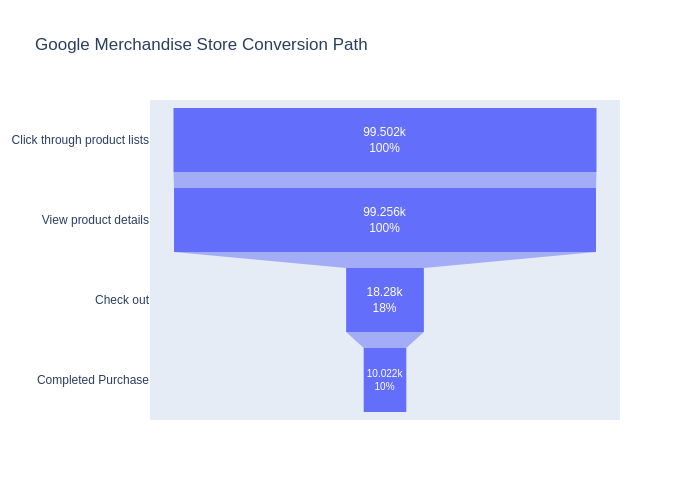

In [37]:
fig = go.Figure(go.Funnel(y = funnel_response['action'], x = funnel_response['users'], textposition = 'inside', textinfo = 'value+percent initial'))
fig.update_layout(title_text = 'Google Merchandise Store Conversion Path')

fig.show()

# Channel & Device Segmentation

## Device Funnel

In [38]:
device_funnel_query = """
SELECT 
    device,
    action,
    users,
    `% of Total`,
    sessions,
    conversion
FROM
(
    SELECT  
      device.deviceCategory as device,
      CASE WHEN hits.eCommerceAction.action_type = '1' THEN 'Click through product lists'
           WHEN hits.eCommerceAction.action_type = '2' THEN 'View product details'
           WHEN hits.eCommerceAction.action_type = '5' THEN 'Check out'
           WHEN hits.eCommerceAction.action_type = '6' THEN 'Completed Purchase'
      END as action,
      COUNT(DISTINCT fullVisitorId) as users,
      COUNT(DISTINCT fullVisitorId) * 100 / MAX(COUNT(DISTINCT fullVisitorId)) OVER (PARTITION BY device.deviceCategory) as `% of Total`,
      SUM(CASE WHEN totals.transactions >= 1 THEN 1 ELSE 0 END)/COUNT(*) AS conversion,
      COUNT(*) as sessions
    FROM 
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) as hits
    WHERE 
      _TABLE_SUFFIX BETWEEN '20160801'
      AND '20170801' AND 
      hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
    
    GROUP BY device, action
)
    ORDER BY device DESC, users DESC
        """
device_funnel_response = google_analytics.query_and_wait(device_funnel_query).to_dataframe()


device_funnel_response

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1965: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



,device,action,users,% of Total,sessions,conversion
0,tablet,View product details,3227,100.000000,10494,0.049647
1,tablet,Click through product lists,3227,100.000000,12509,0.047886
2,tablet,Check out,341,10.567090,2405,0.409979
3,tablet,Completed Purchase,160,4.958165,380,1.000000
4,mobile,Click through product lists,23199,100.000000,78188,0.033765
5,mobile,View product details,23102,99.581879,68141,0.034003
6,mobile,Check out,2450,10.560800,7251,0.464626
7,mobile,Completed Purchase,812,3.500151,1791,1.000000
8,desktop,Click through product lists,73076,100.000000,355063,0.130853
9,desktop,View product details,72927,99.796103,283972,0.138820


Across device types, the funnel pattern is broadly consistent: the most significant drop-off occurs between product views and checkout initiation. This suggests that the friction is likely related to product evaluation or early purchase intent rather than device-specific usability issues. Despite generating fewer sessions than desktop, mobile users show a disproportionately large drop-off between product views and checkouts. Although it doesn't impact total conversions/sessions as strongly as desktop users, it may indicate usability or navigation issues unique to the mobile experience. Depending on our available resources, we can seek to prioritize improvements in the mobile experience or develop broader UX or merchandising optimizations. 

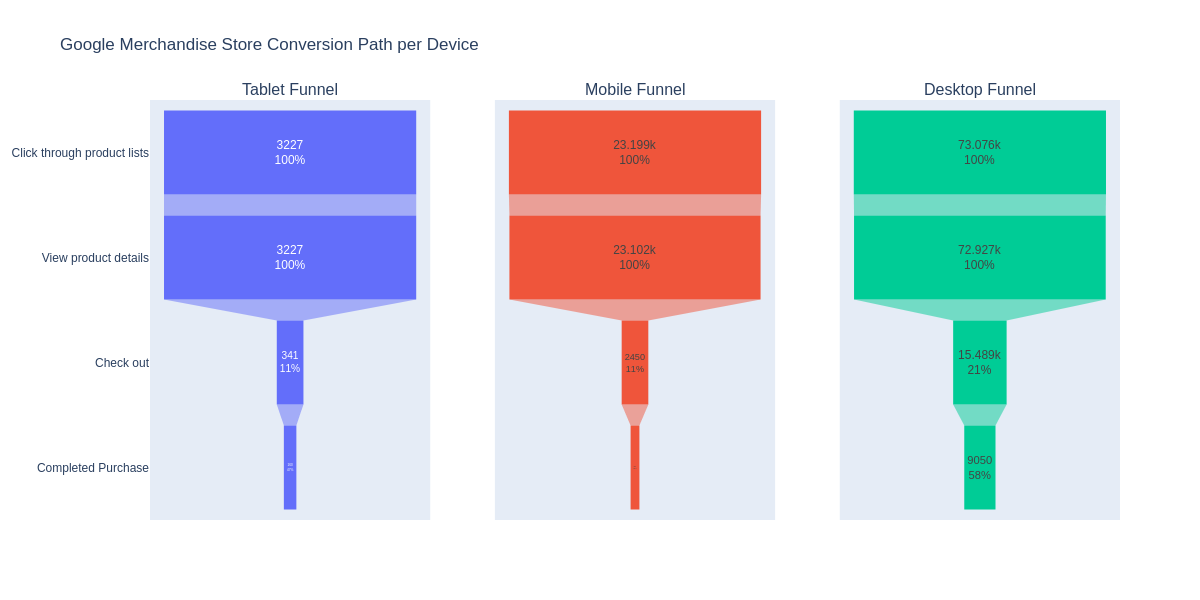

In [39]:
fig = make_subplots(rows=1, cols=3,subplot_titles=("Tablet Funnel","Mobile Funnel", "Desktop Funnel"), shared_yaxes=True)

tablet_data = device_funnel_response[device_funnel_response['device'] == 'tablet'].sort_values(by='sessions', ascending=False)
mobile_data = device_funnel_response[device_funnel_response['device'] == 'mobile'].sort_values(by='sessions', ascending=False)
desktop_data = device_funnel_response[device_funnel_response['device'] == 'desktop'].sort_values(by='sessions', ascending=False)

customdata = [a.lower() for a in tablet_data['action']]

fig.add_trace(
    go.Funnel(
        y = tablet_data['action'], x = tablet_data['users'], textposition = 'inside', textinfo = 'value+percent previous', 
        text=tablet_data['% of Total'].tolist(), customdata = customdata,
        hovertemplate="<b>Tablet</b><br>%{x} users %{customdata} <br>%{text:.2f}% of all Tablet users<extra></extra>"
    ),
    row=1, col=1
)
fig.add_trace(
    go.Funnel(
        y = mobile_data['action'], x = mobile_data['users'], textposition = 'inside', textinfo = 'value+percent previous', 
        text=mobile_data['% of Total'].tolist(), customdata = customdata,
        hovertemplate="<b>Mobile</b><br>%{x} users %{customdata} <br>%{text:.2f}% of all Mobile users<extra></extra>"
    ),
    row=1, col=2
)
fig.add_trace(
    go.Funnel(
        y = desktop_data['action'], x = desktop_data['users'], textposition = 'inside', textinfo = 'value+percent previous', 
        text=desktop_data['% of Total'].tolist(), customdata = customdata,
        hovertemplate="<b>Desktop</b><br>%{x} users %{customdata} <br>%{text:.2f}% of all Desktop users<extra></extra>"
    ),
    row=1, col=3
)
fig.update_layout(title_text = 'Google Merchandise Store Conversion Path per Device', showlegend=False,height=600, width=1200)

fig.show()

## Channel Segmentation

We can also explore the channels that users are making purchases from. The company offers referral and affiliate links along with other channels that serves as another means to segment our customers.

In [40]:
channel_query = """

SELECT  
  DISTINCT trafficSource.medium as traffic_medium,
  COUNT(*) as sessions,
  SUM(totals.transactions) AS transactions,
  SUM(totals.totalTransactionRevenue) / 1000000 AS total_revenue,
  SUM(totals.pageviews) / COUNT(*) AS average_pageviews_per_session,
  SUM(totals.transactions)/COUNT(*) AS conversion
FROM 
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) as hits
WHERE 
      _TABLE_SUFFIX BETWEEN '20160801'
      AND '20170801'
GROUP BY traffic_medium
ORDER BY sessions DESC
        """
channel_response = google_analytics.query_and_wait(channel_query).to_dataframe()


channel_response

,traffic_medium,sessions,transactions,total_revenue,average_pageviews_per_session,conversion
0,(none),2246040,363228,69842914.68,20.661084,0.161719
1,organic,1141113,97332,19504702.25,18.132260,0.085296
2,referral,580309,22040,3501224.27,10.116550,0.037980
3,cpc,88591,9457,1528330.72,19.963676,0.106749
4,affiliate,55860,334,29118.69,9.269101,0.005979
5,cpm,41253,5951,8676307.66,21.934356,0.144256
6,(not set),509,17,203.83,14.795678,0.033399


Referral and affiliate channels attract substantial traffic, yet both underperform in conversion efficiency. Referral traffic converts at approximately 3.8%, and affiliate traffic at just 0.6%, placing them among the lowest-performing channels by conversion rate. Despite this, referral remains a meaningful contributor to revenue, ranking fourth overall. This suggests that while individual sessions convert infrequently, the volume or value of successful transactions offsets the low efficiency.

In contrast, CPM and CPC channels exhibit strong performance profiles. CPM generates the third-highest revenue (over $8 million) despite having one of the lowest session counts, indicating a highly efficient audience segment. Both CPM and CPC achieve elevated conversion rates—about 14% and 10.7% respectively—supporting their role as high-value acquisition channels even with comparatively modest traffic volumes.

These patterns suggest prioritizing optimization for channels with weak conversion but high traffic (e.g., referral), while preserving investment in high-efficiency channels such as CPM and CPC. The affiliate channel may require deeper investigation due to minimal revenue contribution relative to its session volume.

The organic channel generates the largest share of sessions and the highest total revenue, indicating a strong base of users who find the site naturally and often return. Despite this scale, its conversion rate trails several paid channels. Because organic visitors experience the default, non-targeted version of the site, their behavior provides signal on the overall effectiveness of the site’s UX and merchandising. Targeted improvements to navigation, product discovery, and the checkout flow could materially increase conversion within the organic segment and produce broad benefits across all channels.

# Cohort & Retention Analysis

## Establishing cohort groups

We'll observe another key performance indicator: cohort retention. We will define cohorts based on the week that a user initially interacted with the website. Then, we will observe the persistence of cohort activity from the starting week to the most recent month, July 2017.

In [41]:
cohort_query = """
-- Create a table of user cohorts grouped by their first visit week
WITH user_first_visit AS (
  SELECT
    fullVisitorId,
    MIN(DATE(TIMESTAMP_SECONDS(visitStartTime))) AS first_visit_date
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  GROUP BY
    fullVisitorId
),
-- Map each user’s sessions to their cohort and visit week
user_activity AS (
  SELECT
    s.fullVisitorId,
    DATE(TIMESTAMP_SECONDS(s.visitStartTime)) AS visit_date,
    DATE_TRUNC(f.first_visit_date, WEEK(MONDAY)) AS cohort_week,
    DATE_TRUNC(DATE(TIMESTAMP_SECONDS(s.visitStartTime)), WEEK(MONDAY)) AS visit_week
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS s
  JOIN
    user_first_visit AS f
  ON
    s.fullVisitorId = f.fullVisitorId
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
)

-- Count active users per cohort per visit week
SELECT
  cohort_week,
  visit_week,
  COUNT(DISTINCT fullVisitorId) AS active_users,
  DATE_DIFF(visit_week, cohort_week, WEEK) AS weeks_since_first_visit
FROM
  user_activity
GROUP BY
  cohort_week, visit_week
ORDER BY
  cohort_week, visit_week;
        """
cohort_response = google_analytics.query_and_wait(cohort_query).to_dataframe()

## Defining Retention Matrices

In [42]:
def get_last(series):
    if series.last_valid_index() is None:
        return np.nan
    else:
        return series[series.last_valid_index()]

retention_matrix = pd.pivot_table(
    cohort_response,
    values=['active_users'],
    columns='weeks_since_first_visit',
    index='cohort_week'
)

retention_matrix['Last Value'] = retention_matrix.apply(get_last, axis=1)
retention_matrix['Retention Rate'] = retention_matrix['Last Value'] / retention_matrix['active_users'][0] * 100
retention_matrix.drop(columns=['Last Value'], inplace=True)

In [43]:
retention_matrix.sort_values(by='Retention Rate', ascending=False).head(10)

active_users                                          \
weeks_since_first_visit            0      1      2      3      4     5     6   
cohort_week                                                                    
2017-07-31                    4237.0   <NA>   <NA>   <NA>   <NA>  <NA>  <NA>   
2017-07-24                   12152.0  236.0   <NA>   <NA>   <NA>  <NA>  <NA>   
2017-07-17                   12254.0  465.0  105.0   <NA>   <NA>  <NA>  <NA>   
2017-07-10                   12819.0  426.0  239.0   80.0   <NA>  <NA>  <NA>   
2017-07-03                   12593.0  352.0  167.0  149.0   57.0  <NA>  <NA>   
2017-06-26                   13400.0  325.0  198.0  158.0  113.0  45.0  <NA>   
2017-06-05                   10905.0  364.0  178.0  140.0   95.0  79.0  66.0   
2017-06-12                   10744.0  353.0  180.0  122.0  106.0  76.0  59.0   
2017-06-19                   10725.0  339.0  164.0  159.0  136.0  80.0  24.0   
2017-05-22                   10451.0  383.0  209.0  147.0  111.0  83.0  41.0   

                                           ...                                \
weeks_since_first_visit     7     8     9  ...    44    45    46    47    48   
cohort_week                                ...                                 
2017-07-31               <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>   
2017-07-24               <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>   
2017-07-17               <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>   
2017-07-10               <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>   
2017-07-03               <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>   
2017-06-26               <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>   
2017-06-05               61.0  28.0  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>   
2017-06-12               26.0  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>   
2017-06-19               <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>   
2017-05-22               62.0  54.0  49.0  ...  <NA>  <NA>  <NA>  <NA>  <NA>   

                                                Retention Rate  
weeks_since_first_visit    49    50    51    52                 
cohort_week                                                     
2017-07-31               <NA>  <NA>  <NA>  <NA>          100.0  
2017-07-24               <NA>  <NA>  <NA>  <NA>       1.942067  
2017-07-17               <NA>  <NA>  <NA>  <NA>       0.856863  
2017-07-10               <NA>  <NA>  <NA>  <NA>       0.624074  
2017-07-03               <NA>  <NA>  <NA>  <NA>       0.452632  
2017-06-26               <NA>  <NA>  <NA>  <NA>       0.335821  
2017-06-05               <NA>  <NA>  <NA>  <NA>       0.256763  
2017-06-12               <NA>  <NA>  <NA>  <NA>       0.241996  
2017-06-19               <NA>  <NA>  <NA>  <NA>       0.223776  
2017-05-22               <NA>  <NA>  <NA>  <NA>       0.172232  

[10 rows x 54 columns]

The pivot table above visualizes the 10 most recent cohort groupings, where we can already see retention decay over time.  The pivot table below presents 10 cohort groups that started with the active users, which also previews a pattern of retention decay.

In [44]:
retention_matrix.sort_values(by=('active_users', 0), ascending=False).head(10)

active_users                                     \
weeks_since_first_visit            0      1      2      3      4      5   
cohort_week                                                               
2016-11-14                   22820.0  602.0  363.0  230.0  180.0  104.0   
2016-10-24                   22813.0  410.0  256.0  252.0  188.0  155.0   
2016-11-28                   22486.0  656.0  319.0  201.0   96.0  111.0   
2016-11-21                   21903.0  567.0  300.0  218.0  137.0   67.0   
2016-11-07                   21658.0  545.0  296.0  269.0  163.0   98.0   
2016-10-31                   21569.0  475.0  287.0  209.0  212.0  142.0   
2016-10-17                   20041.0  360.0  278.0  220.0  183.0  129.0   
2016-10-03                   16642.0  435.0  261.0  196.0  170.0   91.0   
2016-10-10                   15596.0  417.0  231.0  206.0  156.0  127.0   
2016-12-05                   15461.0  624.0  266.0  142.0  141.0  102.0   

                                                  ...                          \
weeks_since_first_visit      6     7     8     9  ...    44    45    46    47   
cohort_week                                       ...                           
2016-11-14                42.0  61.0  55.0  46.0  ...  <NA>  <NA>  <NA>  <NA>   
2016-10-24                96.0  53.0  43.0  21.0  ...  <NA>  <NA>  <NA>  <NA>   
2016-11-28                69.0  84.0  53.0  48.0  ...  <NA>  <NA>  <NA>  <NA>   
2016-11-21                74.0  42.0  42.0  42.0  ...  <NA>  <NA>  <NA>  <NA>   
2016-11-07                67.0  42.0  44.0  42.0  ...  <NA>  <NA>  <NA>  <NA>   
2016-10-31                68.0  51.0  35.0  35.0  ...  <NA>  <NA>  <NA>  <NA>   
2016-10-17               132.0  86.0  71.0  44.0  ...  <NA>  <NA>  <NA>  <NA>   
2016-10-03               103.0  64.0  80.0  57.0  ...  <NA>  <NA>  <NA>  <NA>   
2016-10-10                98.0  89.0  76.0  64.0  ...  <NA>  <NA>  <NA>  <NA>   
2016-12-05                77.0  68.0  44.0  45.0  ...  <NA>  <NA>  <NA>  <NA>   

                                                      Retention Rate  
weeks_since_first_visit    48    49    50    51    52                 
cohort_week                                                           
2016-11-14               <NA>  <NA>  <NA>  <NA>  <NA>       0.021911  
2016-10-24               <NA>  <NA>  <NA>  <NA>  <NA>       0.030684  
2016-11-28               <NA>  <NA>  <NA>  <NA>  <NA>       0.004447  
2016-11-21               <NA>  <NA>  <NA>  <NA>  <NA>       0.004566  
2016-11-07               <NA>  <NA>  <NA>  <NA>  <NA>       0.009234  
2016-10-31               <NA>  <NA>  <NA>  <NA>  <NA>       0.023181  
2016-10-17               <NA>  <NA>  <NA>  <NA>  <NA>       0.024949  
2016-10-03               <NA>  <NA>  <NA>  <NA>  <NA>       0.024036  
2016-10-10               <NA>  <NA>  <NA>  <NA>  <NA>       0.025648  
2016-12-05               <NA>  <NA>  <NA>  <NA>  <NA>       0.019404  

[10 rows x 54 columns]

### Retention Rate Matrix: General

In [45]:
def calculate_retention(row):
    initial_size = row[0]
    for col in retention_percent_matrix.columns:
        if pd.api.types.is_numeric_dtype(type(row[col])) and row[col] != None:
            row[col] = round(row[col] / initial_size * 100, 3)
    return row

retention_percent_matrix = retention_matrix.drop('Retention Rate', axis=1)
retention_percent_matrix = retention_percent_matrix.apply(calculate_retention, axis=1)

In [46]:
import numpy as np
retention_percent_matrix = retention_percent_matrix.fillna(np.nan).replace([np.nan], [None])

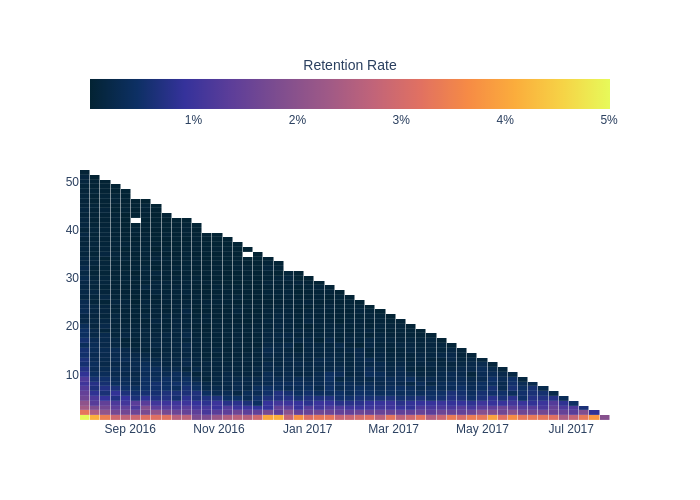

In [47]:

fig = go.Figure(data=go.Heatmap(
                y=[i for i in range(1, 53)],x=retention_percent_matrix.index.tolist(), z=retention_percent_matrix.values[:,1:].T,
                hoverongaps=False, colorscale='thermal', xgap=.5, ygap=.1,
                colorbar=dict(
                    title=dict(
                        text='Retention Rate',
                        side='top'
                    ),
                    orientation='h',
                    x=0.5,
                    y=1.15,
                    tickvals=[i for i in range(6)],
                    ticktext=[str(i)+'%' for i in range(6)],
                    xanchor='center',
                    yanchor='bottom',
                ),
                hovertemplate =
                    'Cohort Group: <b>%{x}</b>'+
                    '<br>Retention by Week %{y}: <b>%{z}%</b><br>'
)
)

fig.update_layout(
    margin=dict(t=100),  # Add top margin so colorbar fits
    plot_bgcolor='rgba(0,0,0,0)',   # Plot area
    paper_bgcolor='rgba(0,0,0,0)'   # Outer area
)

fig.show()

We can observe that the highest values of **Week 2** retention belong to the first three weeks of August 2016 (5% retention rate) and from December 2016 (first two weeks of 4%) and January 2017, outlining key performing months to target in the upcoming months. However, we can see a clear decay pattern where retention tends to wane down around **Week 4** with an average of about 0.96% returning customers from their specified cohort group. Despite October 2016 and November 2016 bringing in the most new users on the website, their retention rates dipped drastically to below 1% by **Week 4 and 5**-suggesting that rapid user acquisition may have come at the cost of user quality or onboarding effectiveness. This presents a critical opportunity: we should conduct a comparative analysis between high-performing cohorts (August 2016's 5% Week 2 retention) and these underperforming ones to identify gaps in traffic sources, user expectations, or onboarding capacity. Additionally, launching re-engagement campaigns targeting these dormant October-November users could recapture value, while implementing improved onboarding processes before the next holiday season will help us convert high traffic into sustained retention.

### Retention Rate Matrix: Device Segment

In [48]:
device_cohort_query = """
-- Create a table of user cohorts grouped by their first visit week
WITH user_first_visit AS (
  SELECT
    fullVisitorId,
    device.deviceCategory as device,
    MIN(DATE(TIMESTAMP_SECONDS(visitStartTime))) AS first_visit_date
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  GROUP BY
    fullVisitorId, device
),
-- Map each user’s sessions to their cohort and visit week
user_activity AS (
  SELECT
    s.fullVisitorId,
    s.device.deviceCategory as device,
    DATE(TIMESTAMP_SECONDS(s.visitStartTime)) AS visit_date,
    DATE_TRUNC(f.first_visit_date, WEEK(MONDAY)) AS cohort_week,
    DATE_TRUNC(DATE(TIMESTAMP_SECONDS(s.visitStartTime)), WEEK(MONDAY)) AS visit_week
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS s
  JOIN
    user_first_visit AS f
  ON
    s.fullVisitorId = f.fullVisitorId AND
    s.device.deviceCategory = f.device
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
)

-- Count active users per cohort per visit week
SELECT
  cohort_week,
  visit_week,
  device,
  COUNT(DISTINCT fullVisitorId) AS active_users,
  DATE_DIFF(visit_week, cohort_week, WEEK) AS weeks_since_first_visit
FROM
  user_activity
GROUP BY
  cohort_week, visit_week, device
ORDER BY
  cohort_week, visit_week, device;
        """
device_cohort_response = google_analytics.query_and_wait(device_cohort_query).to_dataframe()

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1965: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



In [49]:
device_retention_matrix = pd.pivot_table(
    device_cohort_response,
    values=['active_users'],
    columns='weeks_since_first_visit',
    index=['cohort_week', 'device']
).fillna(np.nan).replace([np.nan], [None])

device_retention_percent_matrix = device_retention_matrix.apply(calculate_retention, axis=1)

In [50]:
device_retention_percent_matrix

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



active_users                                     \
weeks_since_first_visit           0      1      2      3      4      5    
cohort_week device                                                        
2016-08-01  desktop            100.0  5.263  3.645  2.663  2.318  1.772   
            mobile             100.0  3.759  1.692  0.940  0.893  0.799   
            tablet             100.0  4.624  1.734  0.867  1.445  1.445   
2016-08-08  desktop            100.0  4.406  2.806  2.055  1.469  1.329   
            mobile             100.0  3.056  1.033  0.947  0.517  0.430   
...                              ...    ...    ...    ...    ...    ...   
2017-07-24  mobile             100.0  1.571    NaN    NaN    NaN    NaN   
            tablet             100.0  1.344    NaN    NaN    NaN    NaN   
2017-07-31  desktop            100.0    NaN    NaN    NaN    NaN    NaN   
            mobile             100.0    NaN    NaN    NaN    NaN    NaN   
            tablet             100.0    NaN    NaN    NaN    NaN    NaN   

                                                     ...                       \
weeks_since_first_visit     6      7      8      9   ...     43     44     45   
cohort_week device                                   ...                        
2016-08-01  desktop      1.600  1.427  1.182  1.363  ...  0.082  0.109  0.091   
            mobile       0.846  0.470  0.423  0.517  ...  0.094  0.141  0.047   
            tablet       1.156  1.156  0.289  0.289  ...    NaN    NaN    NaN   
2016-08-08  desktop      0.944  0.699  0.796  0.586  ...  0.052  0.052  0.087   
            mobile       0.430  0.387  0.344  0.517  ...  0.043  0.043    NaN   
...                        ...    ...    ...    ...  ...    ...    ...    ...   
2017-07-24  mobile         NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN   
            tablet         NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN   
2017-07-31  desktop        NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN   
            mobile         NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN   
            tablet         NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN   

                                                                          
weeks_since_first_visit     46     47     48     49     50     51     52  
cohort_week device                                                        
2016-08-01  desktop      0.082  0.118  0.091  0.082  0.127  0.127  0.045  
            mobile       0.047    NaN    NaN    NaN    NaN  0.047    NaN  
            tablet       0.289    NaN    NaN    NaN  0.289  0.289    NaN  
2016-08-08  desktop      0.035  0.035  0.070  0.044  0.035    NaN    NaN  
            mobile       0.043    NaN  0.043    NaN  0.086  0.043    NaN  
...                        ...    ...    ...    ...    ...    ...    ...  
2017-07-24  mobile         NaN    NaN    NaN    NaN    NaN    NaN    NaN  
            tablet         NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2017-07-31  desktop        NaN    NaN    NaN    NaN    NaN    NaN    NaN  
            mobile         NaN    NaN    NaN    NaN    NaN    NaN    NaN  
            tablet         NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[159 rows x 53 columns]

In [51]:
def plot_device_retention(pivot_table, device):
    pivot_table = pivot_table.xs(device, level='device')
    fig = go.Figure(data=go.Heatmap(
                    y=[i for i in range(1, 53)],x=pivot_table.index.tolist(), z=pivot_table.values[:,1:].T,
                    hoverongaps=False, colorscale='thermal', xgap=.5, ygap=.1, zmin=0, zmax=5,
                    colorbar=dict(
                        title=dict(
                            text='Retention Rate',
                            side='top'
                        ),
                        orientation='h',
                        x=0.5,
                        y=1.15,
                        tickvals=[i for i in range(6)],
                        ticktext=[str(i)+'%' for i in range(6)],
                        xanchor='center',
                        yanchor='bottom'
                    ),
                    hovertemplate =
                        'Cohort Group: <b>%{x}</b>'+ 
                        '<br>Retention by Week %{y}: <b>%{z}%</b><br>'
    )
    )
    
    fig.update_layout(
        margin=dict(t=100),  # Add top margin so colorbar fits
        plot_bgcolor='rgba(0,0,0,0)',   # Plot area
        paper_bgcolor='rgba(0,0,0,0)',   # Outer area
        title_text = f'Cohort Group Retention Rates ({device.title()})', showlegend=False
    )
    fig.show()

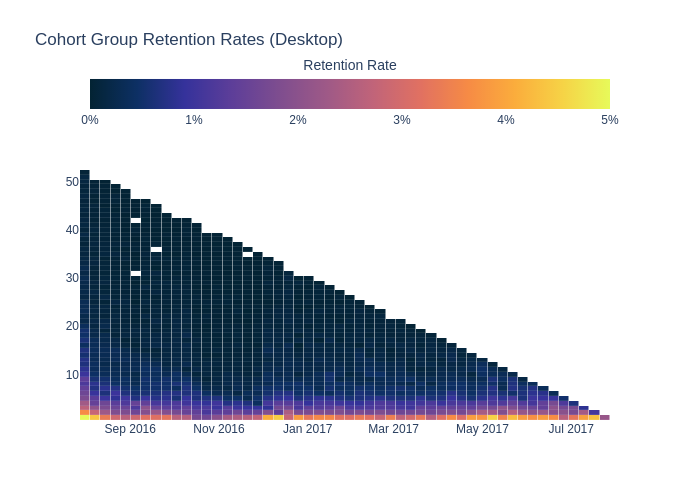

In [52]:
plot_device_retention(device_retention_percent_matrix, 'desktop')

Desktop cohorts demonstrate consistent retention, as there are about ~7 visible gaps between weeks. Desktops cohorts appear to have a brighter distribution between weeks 1 and 7, suggesting a marginal increase in retention when compared to the general audience and a priority audience for platform improvements.

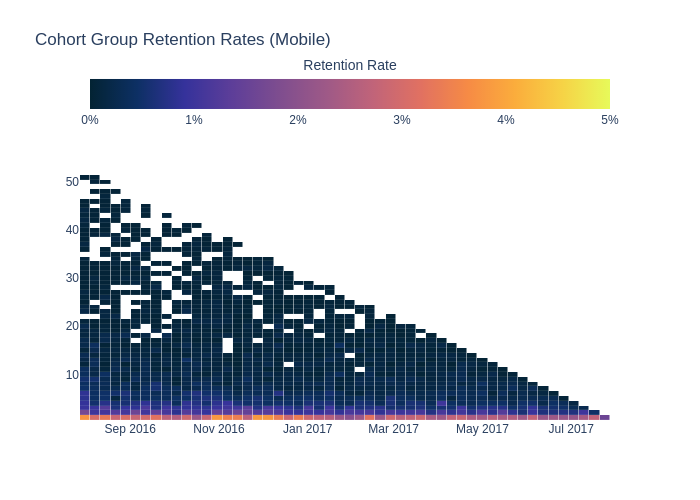

In [53]:
plot_device_retention(device_retention_percent_matrix, 'mobile')

Mobile users show consistently weaker retention after week 1 hovering around 0-1%, suggesting friction in the mobile experience that impacts continued and sustainable engagement. Additionally, there are significantly more gaps, where this pattern is heavily prevalent from August 2016 to November 2016, denoting weeks when there aren't any recorded interactions made by a given cohort. 

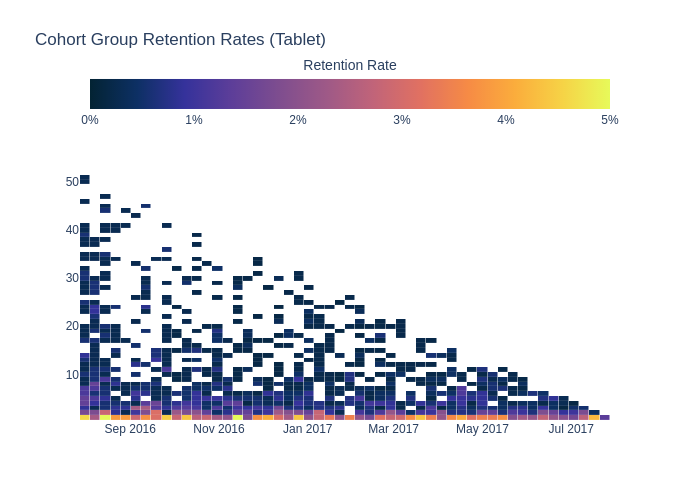

In [54]:
plot_device_retention(device_retention_percent_matrix, 'tablet')

Tablet users demonstrate greater week 1 retention rates compared to mobile users but express significantly more gaps between weeks, suggesting that this device and/or its experience is not conducive for long-term retention. 

Interacting with the website through this medium may be inherently inconsistent, especially if a user has access to other devices (mobile, desktop) that may have a better experience or more frequent updates of the experience. Mobile browsing may observe less retention compared to tablet since it's common to scroll endlessly on mobile and/or the experience simply isn't on par with the other devices. There is an ease that comes with mobile browsing, but the limited screen real estate can be visually daunting and prompt users to use devices with larger screens. For the desktop experience, having a similar pattern to the general plot is sensible due to it drawing the most sessions among the devices. 

# Recommendations

**Based on the funnel drop-offs and device-level retention patterns, the strongest opportunities lie in improving both desktop and mobile experiences.** These devices represent the largest user bases and show the highest long-term retention potential, making them high-leverage areas for optimization.

* **Optimize the Product Detail → Checkout transition.**

    Both the funnel analysis and retention heatmaps indicate a pronounced drop-off at this stage. A focused UX review-covering page load performance, layout clarity, and call-to-action visibility would clarify friction points contributing to abandonment.

* **Test simplified product pages for mobile first, then generalize.**

    Mobile users demonstrate the weakest retention and often drop earlier in the funnel. Beginning with mobile-focused simplifications allows earlier validation of whether streamlined information architecture improves session continuity and purchase completion.

* **Investigate device switching and abandonment behavior.**

    Patterns observed for tablet and mobile users suggest possible cross-device journeys or frustration-driven abandonment. Supplemental methods, such as user surveys or reviewing session stitching logic, would help determine whether users migrate to another device or exit entirely.

* **Evaluate the affiliate channel’s monetization gap.**
 
    Despite meaningful traffic volume, the affiliate channel underperforms in revenue generation. Reviewing landing page quality, alignment between affiliate content and user intent, and attribution logic could clarify whether misalignment or tracking issues drive the mismatch.

These recommendations align directly with the funnel, segmentation, and retention findings, and prioritize changes that realistically improve both conversion and long-term user value.